# Do More with Twitter Data

Twitter is what's happening and what people are talking about right now, with hundreds of millions of Tweets sent each day. We're a group of data scientists on the Twitter Data team who are helping people do more with this vast amount of data in less time. In this spirit, we are starting a series of tutorials that aim to help people work with Twitter data effectively. Each of the posts in this series centers around a real-life example project and provides MIT-licensed code that you can use to bootstrap your projects with our enterprise and premium API products. We hope this series is fruitful for you and we are excited to see what you'll build.

# Evaluating time series and identifying trends


- by Aaron Gonzales, @[binary_aaron](https://twitter.com/binary_aaron), Data Scientist at Twitter, Feb 2018

## #Goals

We have four high-level goals for this tutorial:

- Provide an introduction to thinking about Twitter data, particularly counts of Tweets, from a time-series perspective over longer horizons.
- Discuss interpretable, straightforward analyses to surface interesting points in Twitter data
- Provide reusable code for you to use in querying and working with time-series data 
- Showcase some of the complexities and considerations of doing data science with Twitter (or any) time-series data.


### Caveat

If you have not read the [first tutorial in this series](https://twitterdev.github.io/search-tweets-python/collecting-and-filtering-tweets.html) about how to work with the Twitter Search APIs or refine what rules you use to find Twitter data, please do so. We will not be covering to any depth rule iteration and filtration or the basics of working with the python 
[twittersearch API](https://github.com/twitterdev/twitter_search_api). 

This tutorial assumes familiarity with Python and Pydata programming, basic statistics, and data visualization techniques, though it will be somewhat beginner-friendly.
I'll be using the Python data stack throughout, but most technical users will likely be able to follow along with the methodology and use these concepts in other frameworks (R, Ruby, Julia, Scala, etc).


#### What this tutorial is not

This notebook is not meant to be a tutorial in the Pydata ecosystem (python, pandas, scikit-learn, numpy) or a machine learning tutorial.
We also will not cover building a system to detect trends at scale,
discuss time-series modeling techniques (recurrent neural networks, probabilistic methods, distance-based measures, or using models to detect outliers, etc.), but focusing heavily on first principles of working with time-series data with the unique complexities of Twitter data.

We hope to cover more advanced methods of analysis (complex outlier detection, motifs, time-series similarity, etc.) in another post.

## Outline


- Whose trend is it anyway?
- Counting and displaying Tweet counts with the Search APIs' Counts endpoint
- Transformations
- Combining transformations
- Detrending
- Using transformations with thresholds to find 'spikes'
- Normalizing with another signal
- Rapidly expanding to other signals
- Wrap up

## Whose trend is it anyway?

Before we write any code - What is a trend? A trend is a time-dependent change in system behavior.

Trends are context-specific as different phenomena are measured on different timescales. For example:

- CPU operations or physical particle experiments might be measured in nanoseconds 
- reactive and reinforced sensor systems in robotics or vehicles might operate on millisecond or sub-millisecond time frames
- measuring virality on Twitter or changes in traffic patterns might be measured in minutes
- product launch measurements or business metrics might be collected in daily totals
- public-health or economic records like obesity rates or unemployment might be aggregated as monthly or yearly values
- geologic or astronomical phenomena might be measured in 10-1000s of years

Finding the right time unit for measurement is crucial - using too wide of a time period to measure a phenomena will prevent you from learning about interesting patterns that exist within that bucket, such as cycles, and too small of time frames can make your data very large and quickly unworkable and can also introduce noise into your analysis. Twitter data can be bucketed into any time frame, but is typically done in minutely, hourly, or daily counts. 

Our group has written about trend detection [in a whitepaper](https://github.com/tw-ddis/Gnip-Trend-Detection/blob/master/paper/trends.pdf) to far greater depth if you're interested in a more nuanced treatment of the subject.


### Events and outcomes

Twitter data has often been used as a tool for finding sudden changes in signals. Many of these "trend detection" systems try to identify changes as quickly as possible, often in only a few minutes or hours. 



Common use cases include:

- notification systems for brands so they can manage a PR issue
- flu and disease monitoring systems
- increasing alpha in high-frequency trading or other financial services


Other examples might be thinking about using Twitter data to monitor overall signal for a product or phenomenon, using this as a level of relevant interest. These systems will likely be looking at time frames over days-to-weeks (or years). 


- quantifying interest in or reporting about popular musician over an album or tour cycle
- understanding long-term effects of ad campaigns or one-time events


In this post, we'll be using a retrospective sample of Tweet counts to investigate rapid change detection.

### Running This Notebook

If you want to run this notebook, it is hosted [here](https://github.com/twitterdev/do_more_with_twitter_data). Clone this repo and you'll see this notebook in the `trends` directory.
Please see the accompanying `README.md` file for full instructions. We've provided both a pip-ready `timeseries_requirements.txt` file and a conda environment file, `timeseries_example_conda_env.yml` that allows an easy virtual environment for this example. This example assumes python 3.6.


### Notebook setup

Before we get going with our example, let's set up our working environment. The following cell handles all the imports needed for the session and has some fun notebook tricks. There is a companion file called `timeseries_utils.py` that has code reused from other examples in our series and a few longer methods and rules that we'll import to save space in our notebook.

In [1]:
# reloads libraries when their hash changes
%load_ext autoreload
%autoreload 2

import logging
logging.basicConfig(level="WARN")

import itertools as it

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Our libraries
from tweet_parser.tweet import Tweet
from searchtweets import ResultStream, gen_rule_payload

from IPython.display import HTML
from IPython.core.interactiveshell import InteractiveShell

# load the methods from our auxillary file
from timeseries_utils import (get_frequent_terms,
                               plot_ts,
                               summarize_tweet_text,
                               make_normalplot,
                               pop_star_rules,
                               spotify_popular_artists_rule, 
                               spotify_charts_rule)

# the following makes working in a notebook a bit easier
# as you don't have to have new cells for all output
InteractiveShell.ast_node_interactivity = "all"

# allows for inline plotting
%matplotlib inline

# pretty plots
plt.style.use("bmh")

# better sizing for the notebook
plt.rcParams['figure.figsize'] = (10, 5)

## Working with the Twitter Search API Counts Endpoint

As said earlier, for deeper information on how to use the API, see our [post on getting and filtering data with the search APIs](https://twitterdev.github.io/do_more_with_twitter_data/collecting-and-filtering-tweets.html)


__Credentials__  

Please go ahead and make a YAML file named `.twitter_keys.yaml` in your home directory. 


For premium customers, the simplest credential file should look like this:

```yaml

search_tweets_api:
  account_type: premium
  endpoint: <FULL_URL_OF_ENDPOINT>
  consumer_key: <CONSUMER_KEY>
  consumer_secret: <CONSUMER_SECRET>
```

For enterprise customers, the simplest credential file should look like this:

```yaml

search_tweets_api:
  account_type: enterprise
  endpoint: <FULL_URL_OF_ENDPOINT>
  username: <USERNAME>
  password: <PW>
```


The rest of the example will assume `~/.twitter_keys.yaml` exists, though you can specify your connection information directing in the notebook or using an environment variable if you want. For more information, please see the `searchtweets` [section on credential handling](https://twitterdev.github.io/search-tweets-python/#credential-handling).


The `load_credentials` function parses this file and we'll save the `search_args` variable for use throughout the session.

In [2]:
from searchtweets import load_credentials

search_args = load_credentials(account_type="enterprise") #change to premium as necessary

For the entirety of this post, we'll be using `hourly` count data from the Search API's counts endpoint , and set some arguments to make it easier to query data throughout our session.

My preference is to make use of small functions to handle repetitive analysis tasks. Here, the functions 

- `count_payload_maker`
- `count_collector` 
- `tweet_rule_func`
- `tweet_sample_collector`

wrap arguments we'll use throughout the session, namely start and end dates plus our common API connection information. We'll do this to save some typing and to make a consistent environment, which is particularly useful in a notebook. `count_payload_maker` will convert a rule to a valid JSON payload with our dates and other arguments filled out. 
The `count_collector` function will retrieve up to a year's worth of hourly count results.

These functions work together to give us a valid JSON payload for the API and returning a bag of Tweets or Tweet counts easily.

In [3]:
from functools import partial
from searchtweets import collect_results

from_date = "2017-01-01"
end_date = "2017-12-31"

count_payload_maker = partial(gen_rule_payload,
                              from_date=from_date,
                              to_date=end_date,
                              count_bucket="hour")

# partial allows you to create a new function from an existing one with filled arguments
tweet_rule_func = partial(gen_rule_payload, from_date=from_date, to_date=end_date)
count_collector = partial(collect_results, max_results=365*24, result_stream_args=search_args)
tweet_sample_collector = partial(collect_results, max_results=500, result_stream_args=search_args)

We can also define a simple function that takes our count data and turns it into a nice datetime-indexed pandas `Dataframe`.

In [4]:
def df_from_counts(counts):
    return (pd.DataFrame(counts)
             .assign(timePeriod=lambda df: pd.to_datetime(df["timePeriod"]))
             .set_index("timePeriod")
             .sort_index())

def get_counts_from_rule(rule):
    return df_from_counts(count_collector(count_payload_maker(rule)))

We'll be using a single sample of Tweet counts throughout most of our session: English-language Tweets that mention `"taylor swift"` her username, `@taylorswift13`, or `"tswift"` that are not Retweets. Our results can be obtained quickly:

In [5]:
_taylor_rule = '(@taylorswift13 OR "taylor swift" OR tswift) -is:retweet lang:en'
# this is the payload
print(count_payload_maker(_taylor_rule))

{"query":"(@taylorswift13 OR \"taylor swift\" OR tswift) -is:retweet lang:en","toDate":"201712310000","fromDate":"201701010000","bucket":"hour"}


In [6]:
df = get_counts_from_rule(_taylor_rule)

In [7]:
print(f"API requests used so far: {ResultStream.session_request_counter}")

API requests used so far: 12


It's always a great idea to start with some description and visualization of your data, so let's do that. There is a function, `plot_ts`, in the companion file `timeseries_utils.py` that serves as a flexible plotting function for our time series.

total tweets counted: count    5262402
dtype: int64
hourly bin summary 

             count
mean    602.381181
std    1097.621700
min     111.000000
25%     249.000000
50%     348.000000
75%     589.000000
max   36722.000000


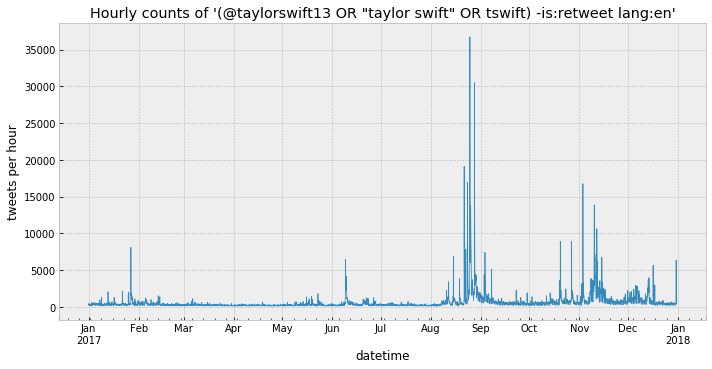

In [8]:
print("total tweets counted: {}".format(df.sum()))
print("hourly bin summary \n")
print(df.describe().drop("count", axis=0))

plot_ts(df, raw=True, title=f"Hourly counts of '{_taylor_rule}'");

Taylor Swift is popular - the minimum amount of Tweets per hour in the sample is ~100, and the max is ~36000.
Our total Tweet volume is ~5.3 million Tweets!
However, by visual inspection, her Tweet volumes are not at all "normal" and have very spiky behavior around certain dates, jumping several orders of magnitude from a hourly median of about 350 Tweets per hour.

Given this very skewed distribution, it's also difficult to discern a long-term trend with her data.

Before we look at Tweets to see what is going on, we'll continue talking about our series a bit.

Let's see what a histogram  and a log-transformed histogram look like:

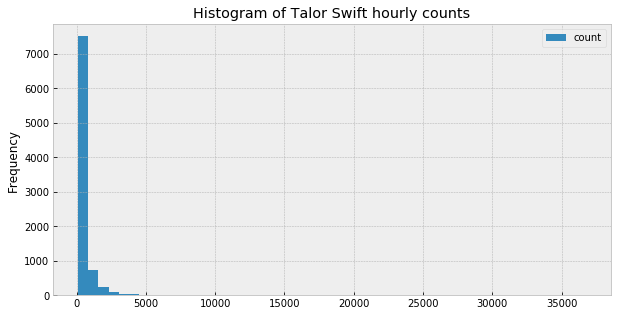

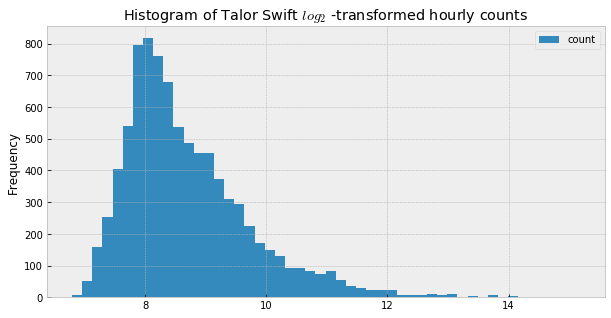

In [9]:
df.plot.hist(bins=50, title="Histogram of Talor Swift hourly counts");
np.log2(df).plot.hist(bins=50,
                      title="Histogram of Talor Swift $log_2$ -transformed hourly counts");

As with many phenomena on the internet, the data is highly skewed and not quite log-normal, with a huge volume of the overall data coming from a small number of days. 

Most analyses will require some type of filtering or transformations to be useful, similar to basically all of the data science world. Let's examine a handful of basic methods.

#### Resampling

The Twitter Search API's `Counts` endpoint can return data in daily, hourly, or minutely buckets. For the purpose of this example, we are sticking with hourly data, but in many cases there are reasons to get the highest-frequency data you can muster and do your own resampling as needed.
Daily counts are great for getting a quick look at a Tweet volume or estimating / refining rules over longer periods, and might be useful for longer-term analyses, but are also clearly not fine enough to detect very small changes in the data that occur within a 24h period. With hourly data, you'll see natural patterns in the data (in our rule, Tweet volumes will peak in the US daytime and drop in the US evening hours, due to more English-speaking users being in North America than elsewhere). 

Note that the time returned is UTC. For example, see the below plot of a few days - mind the noticeable dip in Tweets during North American nighttime.

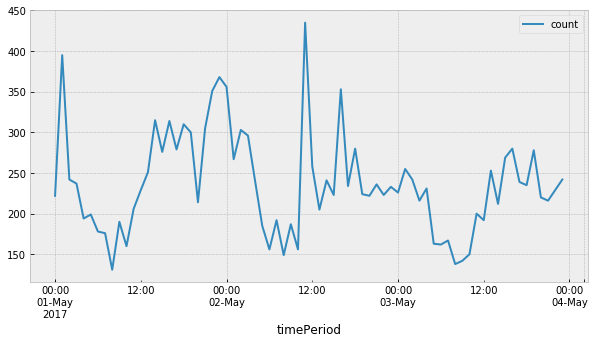

In [10]:
df["2017-05-01":"2017-05-03"].plot(kind="line");

We can resample our data to daily counts and see our longer-term trend info a bit more clearly, while losing some of the fidelity as well as the daily seasonality.

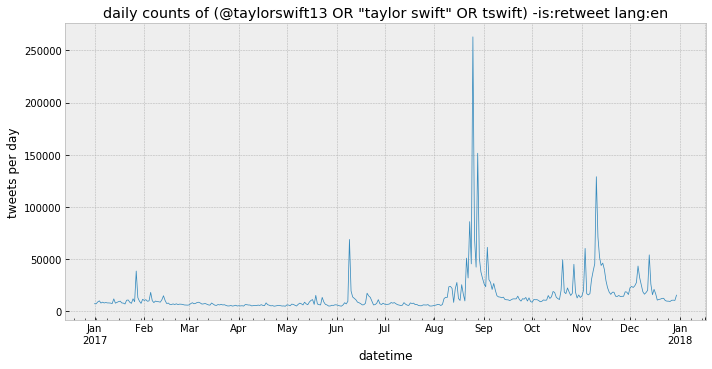

In [11]:
daily_df = df.resample("D").sum()
plot_ts(daily_df,
        raw=True,
        title=f"daily counts of {_taylor_rule}",
        y_label="tweets per day");

## Transformations and Preliminary Work

We'll cover three classes of ways to transform your time-series data to deal with various issues that arise in time-series analysis. These areas are categorized as follows:

1. Scaling methods - Standardization, log-transforms, median absolute deviance
2. Differencing - differences and percentage changes
3. Rolling methods - rolling means and exponentially-weighted windows

We will also discuss combining these methods.


### Scaling Methods

#### Standardization

As with other data, we can put it into a [standardized score](https://en.wikipedia.org/wiki/Standard_score) (or Z-score) so that we might compare it to other non-similarly based signals. Our transformed units are $\sigma$, deviations from the mean. Recall that in both directions:

- $\pm 1 \sigma$ covers ~68% of the data
- $\pm 2 \sigma$ covers ~95% of the data
- $\pm 3 \sigma$ covers ~99.7% of the data

A plot of a random normal dataset after standardization will look like the following plot. I've added bands that correspond to 1, 2, and 3 $\sigma$ from the mean.

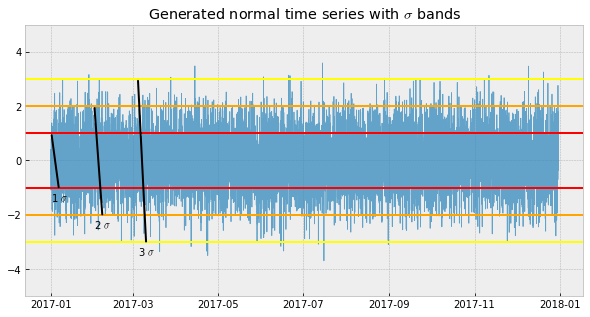

In [12]:
make_normalplot(df, random=True)

We already know that our Tweet data is not normally distributed. Standardization does nothing to the *shape* of the Tweets, but does scale it down to a common value. Let's see what it looks like:

Note - my usage of pandas' `.pipe` notation might be confusing: `pipe` pushes the current `DataFrame` into a new function that takes a `DataFrame` as an argument.
It's wildly useful for chaining together operations, which is common in our line of work, and keeps our namespace clean, and is oft referred to as [method chaining](https://en.wikipedia.org/wiki/Method_chaining). `df.pipe(standardize)` is the same as `standardize(df)`, but as we add more complex processing chains, the `.pipe` function makes it easier to follow what is happening. If you have worked with pipes in unix-based operating systems before, the concept is similar. For more info, you can see [this wonderful Pandas tutorial series](https://tomaugspurger.github.io/method-chaining).

The below function works in a `DataFrame` and will standardize all columns.


In [13]:
def standardize(df):
    """
    Put the data in the dataframe in units of deviation from the mean.
    """
    return (df - df.mean()) / df.std()

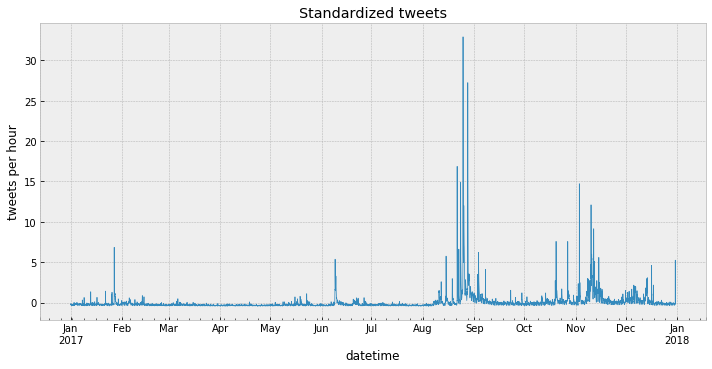

In [14]:
(df
 .pipe(standardize)
 .pipe(plot_ts,
       raw=True,
       title="Standardized tweets"));

There is a interesting pattern in our dataset. The standardized scores reflect our highly skewed set of Tweets, and we can also see a faint notion that the mean of the data is changing with time.
This is very common in many real-life datasets, and will render many statistics quite meaningless or at least poor descriptors of the data.

We can say that a time-series that has a non-time-dependent mean is *stationary*, and one whose mean varies with time is *non-stationary*.
Many methods will depend on making series stationary.
Often visualization can quickly identify a non-stationary dataset, and in our examples we'll stick with that, but there is a statistical test called the [augmented Dickey-Fuller test](https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test) that will test if your series is stationary. We recommend reading about it and using it, though it may not handle extremely spiky data like this well. 

#### Log Transformations

A log transformation converts any multiplicative patterns in our data to additive patterns, and the rescaling can be quite helpful for *visual* inspection as well. It now looks like there are a few patterns here - the big spikes in the data are preceded by a small ramp up period, and the drop-off after the peaks might have an upward tick trend for a while as well. It does seem that the mean does appear to vary over time, possibly 4x greater after September than in early parts of the year.

($log_2$ can be nice for plotting, as powers of two are easier to interpret quickly than powers of $e$. For transforming or operations, natural logs can be preferred and often have nice numerical properties.)

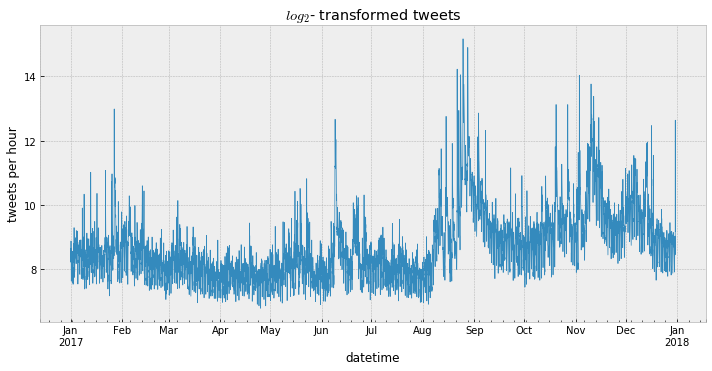

In [15]:
(df
 .pipe(np.log2)
 .pipe(plot_ts,
       raw=True,
       title="$log_2$- transformed tweets"));

Log transformation before standardization helps give more reasonable standardized values, even if the log-transform isn't quite enough to make this data normal. The plot below has the same $\sigma$ bands as demonstrated earlier for visual clarity. 

Notice that we haven't yet dealt with our stationarity yet, and most of the below-average days are shifted due to the mean drift over time.

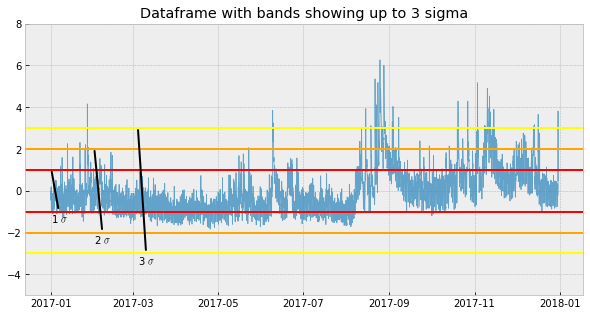

In [16]:
(df
 .pipe(np.log)
 .pipe(standardize)
 .pipe(make_normalplot, random=False))

### Median Deviance

Another important transform, we can use a metric like mean absolute deviance or its robust cousin, median absolute distance, to transform our signal into how far away a given time interval is from the median. Absolute measures of distance / deviance are far more tolerant of both larger values and outliers in the data than means / standard deviations. Recall that the sample standard deviation is 

$$ s = \sqrt{\frac{\sum_{i=1}^N (x_i - \overline{x})^2}{N-1} } $$

and the median absolute deviation is

$$ MAD = median( |X_i - median(X)|) $$


The squared error in the standard deviation makes outliers have far greater influence on the overall statistic.

The data can be put into units of deviance, similar to a z-score, by dividing each median-subtracted point by the overall median absolute deviation of the signal. These points are far more robust to outliers and shape than working with means and standard deviations, and have a rough correspondence to normalized z scores - values over "2" will be roughly > 90% of other values and so forth. For more information, please see [here](https://en.wikipedia.org/wiki/Median_absolute_deviation).
MAD is a key component in a time-series anomaly detection method that Twitter [published a few years ago](https://blog.twitter.com/engineering/en_us/a/2015/introducing-practical-and-robust-anomaly-detection-in-a-time-series.html). 

Enough chat, let's see some plots.

In [17]:
def median_abs_dev(df, constant=None):
    if constant is None:
        # allows us to use the MAD to roughly approximate to the standard deviation
        # see the wikipedia page
        constant = 1.4826
    # rolling will take numpy arrays
    abs_dev = constant * np.median(np.abs((df - np.median(df))))
    return abs_dev
    

def mad_normalize(df, constant=None):
    # puts this dataframe into multiples of the MAD, similar to Zscoring
    # abs(x - median(x)) / MAD(df)
    return (df
             .sub(np.median(df))
             .pipe(np.abs)
             .div(median_abs_dev(df)))

median abs deviation of total sample: 186.80759999999998
median abs deviation of total ln-trans sample: 0.5947657852571288


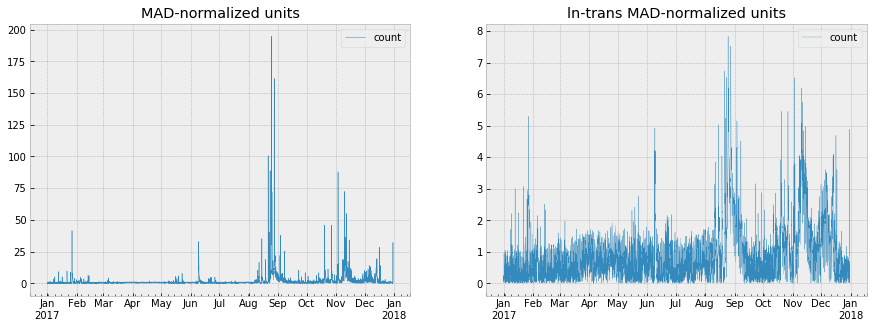

In [18]:
print("median abs deviation of total sample: {}".format(df.pipe(median_abs_dev)))
print("median abs deviation of total ln-trans sample: {}".format(df.pipe(np.log).pipe(median_abs_dev)))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (15, 5))

#fig.tight_layout()
[ax.xaxis.label.set_visible(False) for ax in axes.ravel()]
(df
 .pipe(mad_normalize)
 .plot(ax=axes[0],
       lw=0.5,
       title="MAD-normalized units"));
(df
 .pipe(np.log)
 .pipe(mad_normalize)
 .plot(ax=axes[1],
       lw=0.3,
       title="ln-trans MAD-normalized units"));

### Differencing Methods

#### Simple Difference

There are other ways we should think about our time series - we can transform it into a differenced series, where we subtract the previous observation (or $t-t_{n}$ observation) from the current observation. Differencing is a key method for making a non-stationary series stationary.

              count
count   8735.000000
mean       0.026216
std      700.083421
min   -20713.000000
25%      -48.000000
50%       -4.000000
75%       39.000000
max    28127.000000


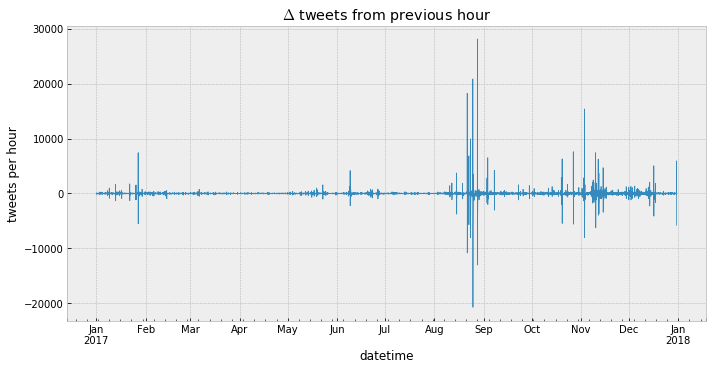

In [19]:
print(df.diff().describe())
(df
 .diff()
 .pipe(plot_ts,  raw=True,
       title="$\Delta$ tweets from previous hour")
);

#### Percentage changed

We can also think about Tweet count deltas as a percentage change over some period. Here, we show both the % change from the previous hour.

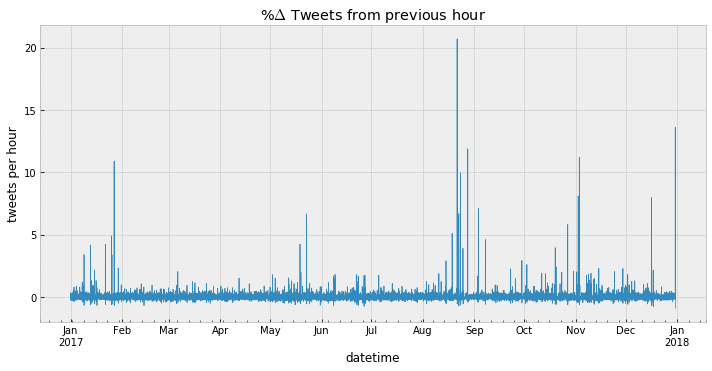

In [20]:
plot_ts(df.pct_change(),
        raw=True,
        title="%$\Delta$ Tweets from previous hour");

### Combining  Transformations

Combining our transformations is powerful and a common pre-processing technique. We can apply a difference transform and then normalize via standardization or MAD, and/or add a log-transform. 

Log-differences look somewhat more normally distributed, though we have some very large values still present in our data. The MAD-normalized values have far more large values present due to the MAD's high sensitivity to outliers.

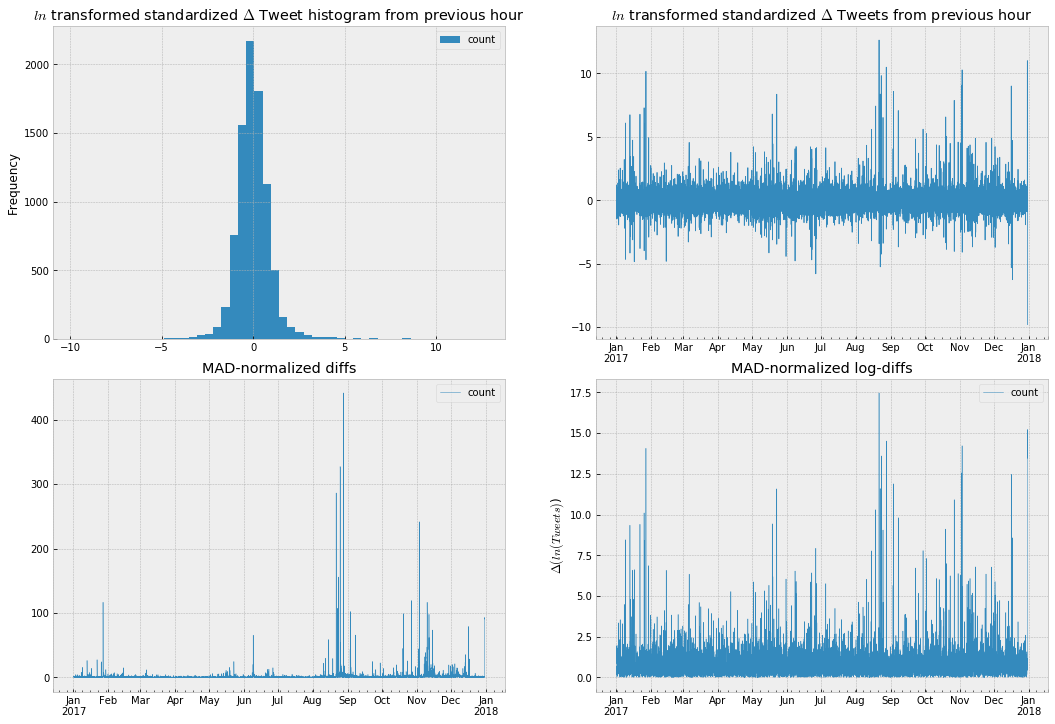

In [21]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize = (15, 10));

[ax.xaxis.label.set_visible(False) for ax in axes.ravel()];


(df
 .pipe(np.log)
 .diff()
 .pipe(standardize)
 .plot
 .hist(bins=50,
       ax=axes[0][0],
       title="$ln$ transformed standardized $\Delta$ Tweet histogram from previous hour"));

plot_ts(df.pipe(np.log).diff().pipe(standardize),
        raw=True,
        title="$ln$ transformed standardized $\Delta$ Tweets from previous hour", 
        y_label="$\Delta (ln(Tweets)$)", custom_ax=axes[0][1],
       );


(df
 .diff()
 .dropna()
 .pipe(mad_normalize)
 .plot(ax=axes[1][0],
       lw=0.5,
       title="MAD-normalized diffs"));

(df
 .pipe(np.log)
 .diff()
 .dropna()
 .pipe(mad_normalize)
 .plot(ax=axes[1][1],
       lw=0.5,
       title="MAD-normalized log-diffs"));


### Moving/Rolling statistics

A moving window can be defined as a fixed-size array that moves over your data. Each window can define a function that operates on the current set of values within your data and returns a single (reduction) or range of values. Note that this is the same as a 1-dimensional convolution with a kernel of length $k$, where $k$ is the length of your window.

Moving averages are one of the most common transformations in time-series work. The moving average is a way to "smooth" your signal according to a the length of the window. The moving average at point $t$ is the mean value of all points prior to $t$ in your window. Longer windows will be slower to react to changes in the signal and reveal low-frequency information; shorter windows are faster to react to changes in the signal and reveal higher frequencies. 

Let's take our signal and plot it with several moving average windows - 1 day, 7 day, and 14 days. 

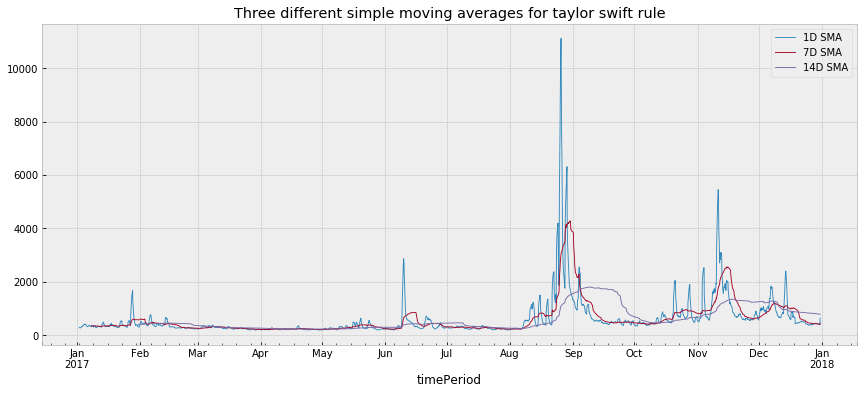

In [22]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize = (12, 5))
fig.tight_layout()
df.rolling(24).mean().rename(columns={"count": "1D SMA"}).plot(ax=axes, lw=0.9);
df.rolling(24 * 7).mean().rename(columns={"count": "7D SMA"}).plot(ax=axes, lw=0.9);
df.rolling(24 * 30).mean().rename(columns={"count": "14D SMA"}).plot(ax=axes, lw=0.9);
axes.set_title(label="Three different simple moving averages for taylor swift rule");


As stated before, longer moving windows represent lower-frequency signals and shorter windows represent higher-frequency signals. In the above chart, notice how the 14-day SMA doesn't have a visible "peak" until far after both the 1 and 7-day SMAs. 



We can apply other statistics to the window, such as the median - giving us the simple moving median (SMM). Let's compare a SMA with the SMM.

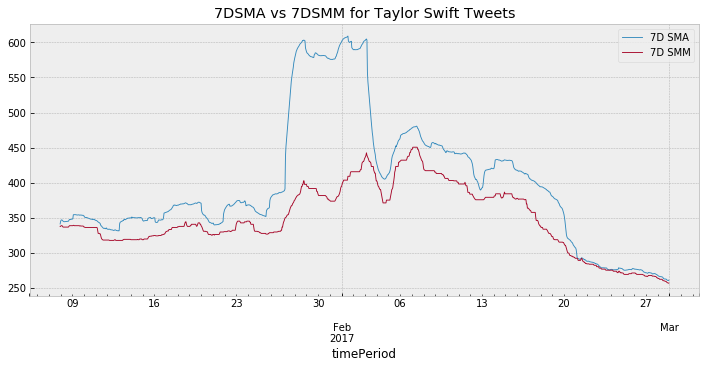

In [23]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize = (12, 5))

(df
 .rolling(24*7)
 .mean()
 ["2017-01":"2017-02"]
 .rename(columns={"count": "7D SMA"})
 .plot(ax=axes, lw=0.9));

(df
 .rolling(24*7)
 .median()
 ["2017-01":"2017-02"]
 #["2017-08"]
 .rename(columns={"count": "7D SMM"})
 .plot(ax=axes, lw=0.9));

axes.set_title(label="7DSMA vs 7DSMM for Taylor Swift Tweets");

Notice how the SMA is more reactive than the SMM. The median is always less sensitive to outliers and spikes in our data.

#### Exponentially-weighted windows


Exponentially-weighted moving windows (EWM) model the underlying data more closely, weighting more recent samples higher than samples earlier in the window. Let's zoom in on a smaller date range and show the raw data, 8-hour span EWMA, and 48-hour EWMA.

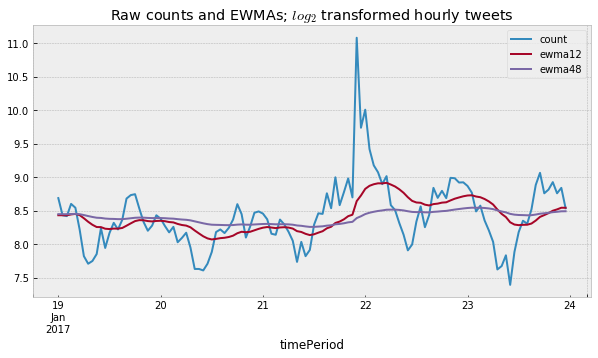

In [24]:
(df
 .pipe(np.log2)
 .assign(ewma12=lambda x: x.ewm(12).mean())
 .assign(ewma48=lambda x: x["count"].ewm(48).mean())
  ["2017-01-19":"2017-01-23"]
 .plot(title="Raw counts and EWMAs; $log_2$ transformed hourly tweets")
);

The rest of this post will not make use of EWM windows, but they are an important transformation to various indicators in other domains, like finance. Financial indicators could be useful in Twitter data as well, and we might cover a post about them in the future. For the interested reader, we suggest reading about various indicators from [StockCharts](http://stockcharts.com/school/doku.php?id=chart_school:technical_indicators).

### Detrending a time series

Remember our above discussion about stationarity in time-series? We've talked about differencing as a method for making a non-stationary series stationary, but there are other ways of detrending. 

Moving statistics are commonly used to help detrend a time-series. The moving window can be thought of as the trend itself, and taking the difference between the original data and its trend will take out the shifting mean and variance, allowing us to revisit standardization and model our series.

The below function is a simple method to do this, and will default to a 24-hour simple moving average. Let's look at the visualizations below:

In [25]:
def detrender(df, periods=None, method=None):
    periods = 24 if periods is None else periods
    func = np.mean if method is None else method
    
    return df - df.rolling(periods).apply(func)

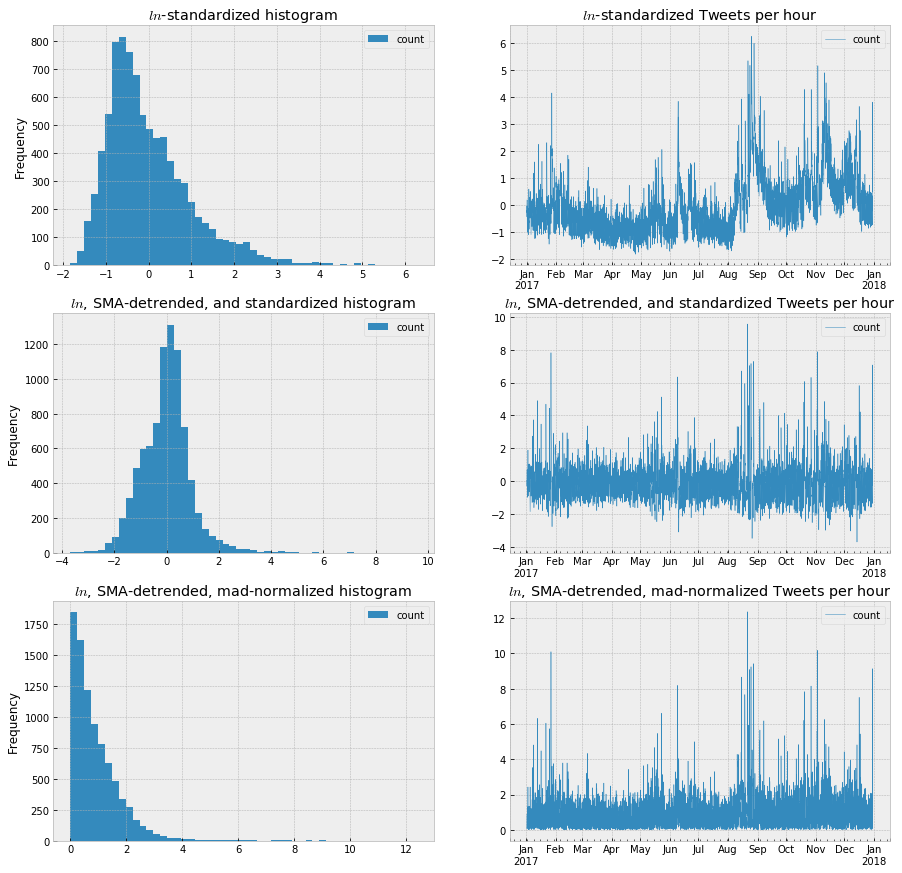

In [26]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize = (15, 15))
[ax.xaxis.label.set_visible(False) for ax in axes.ravel()]

(df
 .pipe(np.log)
 .pipe(standardize)
 .plot
 .hist(bins=50,
       title="$ln$-standardized histogram",
       ax=axes[0][0]) );

(df
 .pipe(np.log)
 .pipe(standardize)
 .plot(ax=axes[0][1],
       lw=0.5,
       title="$ln$-standardized Tweets per hour"));


(df
 .pipe(np.log)
 .pipe(detrender)
 .pipe(standardize)
 .plot
 .hist(bins=50,
       title="$ln$, SMA-detrended, and standardized histogram",
       ax=axes[1][0]) );

(df
 .pipe(np.log)
 .pipe(detrender)
 .pipe(standardize)
 .plot(ax=axes[1][1],
       lw=0.5,
       title="$ln$, SMA-detrended, and standardized Tweets per hour"));

(df
 .pipe(np.log)
 .pipe(detrender)
 .dropna()
 .pipe(mad_normalize)
 .plot.hist(ax=axes[2][0], bins=50,
       #lw=0.5,
       title="$ln$, SMA-detrended, mad-normalized histogram"));
(df
 .pipe(np.log)
 .pipe(detrender)
 .dropna()
 .pipe(mad_normalize)
 .plot(ax=axes[2][1],
       lw=0.5,
       title="$ln$, SMA-detrended, mad-normalized Tweets per hour"));

The scores are not quite normal and have a hair of skew left, but we can see how the drift in the mean over time has been removed, which makes our standardized and MAD-normalized values more valid.

### Recap

So, we have covered several methods of doing basic transformations:

- log transformation
- standardization (z-scoring)
- median absolute deviation
- differencing
- percentage changes
- rolling statistics
  - mean
  - median
  - exponential weighting
- detrending



All of these methods can be used to quickly put your signal into a new frame of reference, and are fundamental for detecting changes based on *thresholds*. Let's consider three examples:


- Using our rolling MAD plot, we could say that if a value, say, $\eta$ exceeds some number of Tweets, we mark it as a major deviance from the series.
- If the basic percentage change of a time bin is > 200% of the previous bucket, we signal it.


Let's demonstrate a few simple spike detectors. We're going to:

- $ln$-transform the Tweet counts data
- detrend it by subtracting a rolling mean or median or via `.diff()`
- standardize or MAD-normalized the results
- select anything that is over 4 normalized units away from 0.


Our `plot_ts` function will put point markers on our Tweet signal given a set of dates. The order of our threshold-based detectors goes from *least* sensitive to *most* sensitive, as you can see.

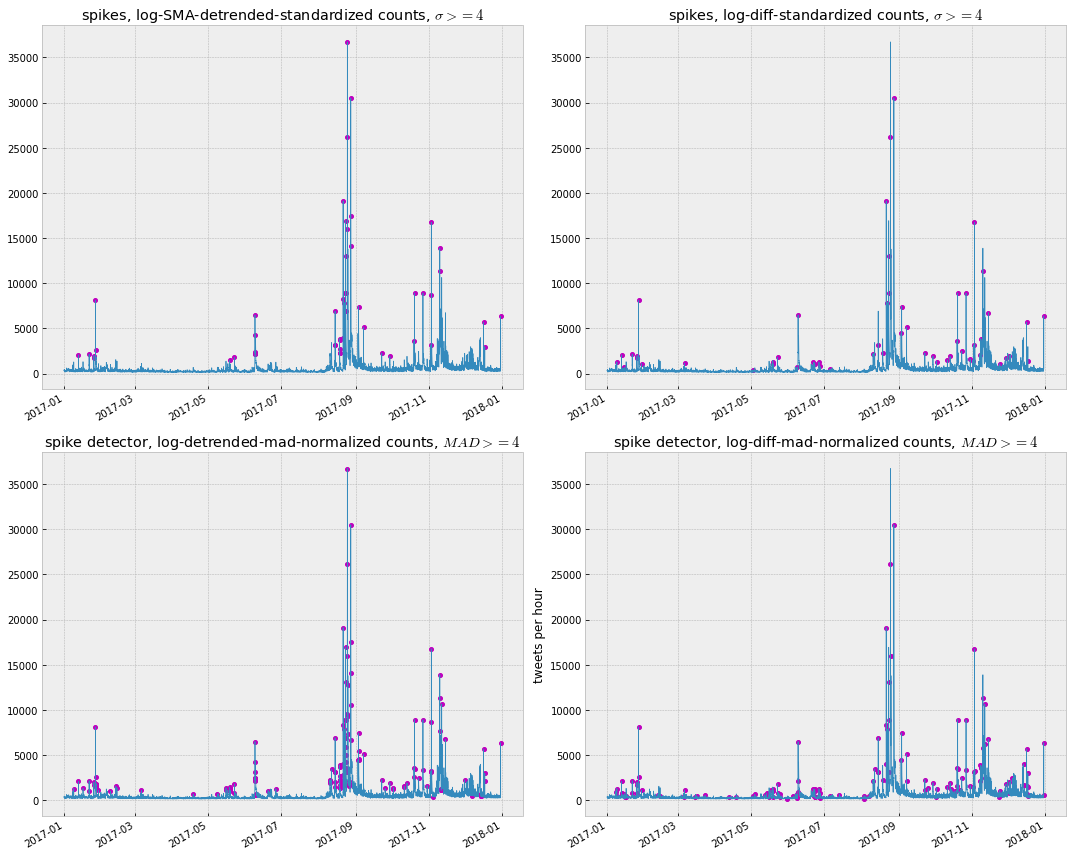

In [27]:
UNIT_THRESHOLD = 4
fig, axes = plt.subplots(nrows=2, ncols=2, figsize = (15, 12))
[ax.xaxis.label.set_visible(False) for ax in axes.ravel()]

plot_ts(df,
        raw=True,
        title=f"spikes, log-SMA-detrended-standardized counts, $\sigma >={UNIT_THRESHOLD}$",
        custom_ax=axes[0][0],
        date_markers=(df
                      .pipe(np.log)
                      .pipe(detrender)
                      .dropna()
                      .pipe(standardize)
                      .query("count >= @UNIT_THRESHOLD")
                      .index));

plot_ts(df,
        raw=True,
        title=f"spikes, log-diff-standardized counts, $\sigma >={UNIT_THRESHOLD}$",
        custom_ax=axes[0][1],
        date_markers=(df
                      .pipe(np.log)
                      .diff()
                      .pipe(standardize)
                      .query("count >= @UNIT_THRESHOLD")
                      .index));
                      
plot_ts(df,
        raw=True,
        title=f"spike detector, log-detrended-mad-normalized counts, $MAD >={UNIT_THRESHOLD}$",
        custom_ax=axes[1][0],
        date_markers=(df
                      .pipe(np.log)
                      .pipe(detrender, method=np.median)
                      .dropna()
                      .pipe(mad_normalize)
                      .query("count >= @UNIT_THRESHOLD")
                      .index));

plot_ts(df,
        raw=True,
        title=f"spike detector, log-diff-mad-normalized counts, $MAD>={UNIT_THRESHOLD}$",
        custom_ax=axes[1][1],
        date_markers=(df
                      .pipe(np.log)
                      .diff()
                      .dropna()
                      .pipe(mad_normalize)
                      .query("count >= @UNIT_THRESHOLD")
                      .index));

This process can be used to find an offline threshold value that works for your problem at hand. We typically prefer to use robust methods where possible, and like the simplicity of the log-diff-MAD normalization method.
To be sure, our threshold for these plots was a MAD score $>=4$, which is interpreted as greater than four times the median absolute deviation for the dataset in a single hourly bin.
Note that some of these scores are very high, in the 15+ range.

We can take a quick look at some of the tweets from one of the top dates and summarize the text with the following code, most of which lives in the companion file, `trends_utils.py`.

In [28]:
top_dates = (df
             .pipe(np.log)
             .diff()
             .dropna()
             .pipe(mad_normalize)
             .sort_values(by="count", ascending=False)
             .head()
             .index
             .values)
sample_date = [str(x)[:16] for x in top_dates][0]
sample_date

'2017-08-21T15:00'

In [29]:
TWEET_SAMPLE_SIZE = 7500
tweet_samp = collect_results(gen_rule_payload(_taylor_rule, to_date=sample_date),
                             result_stream_args=search_args,
                             max_results=TWEET_SAMPLE_SIZE)

In [30]:
summarize_tweet_text(tweet_samp, samples=15)

-----------------start summary-----------------------------
	----sample tweets ----
tweet text:
 	 TAYLOR
SWIFT
IS
FUCKING
COMING
SO
YALL
BETTER
SAVE
MONEY
FOR
THE
SONGS
THE
ALBUMS
THE
TOUR
LITERALLY
EVERYTHING
TS6
IS
COMING
TO
END
US
ALL. 
 favs: 	 2398

tweet text:
 	 .@mrBobbyBones knows too much... about @taylorswift13 and what's going to happen today.

WE WANNA KNOW. https://t.co/aIG9etpm9u 
 favs: 	 2131

tweet text:
 	 Tomorrow 4am expect something from @taylorswift13 
Our expert on all things #TaylorSwift said so!! https://t.co/vMBFD0DZ1E 
 favs: 	 2090

tweet text:
 	 Me dancing to Taylor Swift's  unannounced, unreleased, not even anywhere remotely near confirmed new single  

#TS6IsComing https://t.co/IU8DhUeTr7 
 favs: 	 2072

tweet text:
 	 .@SimonCowell was right when he said @GraceVanderWaal was the next @taylorswift13. #AGT https://t.co/Aq8KNRm3tX 
 favs: 	 1730

tweet text:
 	 Taylor Swift is BACK! Sources say she's releasing new music and thinks it's the best she's eve

Looks like this happened right when news dropped that Taylor Swift was going to announce an album, but there are also sample terms related to a verdict about a [lawsuit that she won](https://www.cnn.com/2017/08/14/entertainment/taylor-swift-verdict/index.html). Further inspection will be left as an exercise for the curious reader.

## Normalization


What about providing some context to our Taylor Swift Tweet counts? 

How can we potentially increase the value of what we are measuring? Let's introduce a way to "normalize" our time series, such that we find a reasonable baseline that is contextually related to our example.

Given that we are using Tweets about a pop star, perhaps a good starting point might to collect Tweet data from a bunch of popular musicians and use that as a "baseline" measure.

The choice of a normalizing signal is **crucial** and **should done with care**. Use your domain knowledge or consult your experts about it, as a different signal may have wildly different effects on your results. Go through proper rule iteration and filtering to ensure you are measuring the right thing. You could also use multiple normalizations, using the mean between them to get a more robust and less noisy normalization signal.

For starters, we'll pull count data for an aggregate of popular artists on Spotify. The rule is defined in the `timeseries_utils.py` file, and we'll show it here.

This comprises what one can assume is a halfway reasonable sample of popular musicians, though there are some problems that pop up immediately:

- genres are not always the same as Taylor Swift
- some artists might be very popular in specific countries (think the UK) that might have effects on the daily periodicity we see
- some of these artists might be new
- some of these artists will be extremely popular in spurts
- some of these artists will need rule refinement (e.g., "Future")

Fixing these issues will be left as an exercise for the reader.

In [31]:
print(spotify_charts_rule)


(
"Post Malone" OR @PostMalone OR
"Lil Pump" OR @lilpump OR
"Camila Cabello" OR @Camila_Cabello OR
"Offset" OR @OffsetYRN OR
"G-Eazy" OR @G_Eazy OR
"A$AP Ferg" OR @burdxkeyz OR
"21 Savage" OR @21savage OR
"Sam Smith" OR @samsmithworld OR
"Migos" OR @Migos OR
"Ed Sheeran" OR @edsheeran OR
"Logic" OR @Logic301 OR
"Khalid" OR @thegreatkhalid OR
"Gucci Mane" OR @gucci1017 OR
"Maroon 5" OR @maroon5 OR
"Bebe Rexha" OR @BebeRexha OR
"Marshmello" OR @marshmellomusic OR
"Hailee Steinfeld" OR @HaileeSteinfeld OR
"Cardi B" OR @iamcardib OR
"Halsey" OR @halsey OR
"Kodak Black" OR @KodakBlack1k OR
"Kendrick Lamar" OR @kendricklamar OR
"Travis Scott" OR @trvisXX OR
"XXXTENTACION" OR @xxxtentacion OR
"French Montana" OR @FrencHMonTanA OR
"Demi Lovato" OR @ddlovato OR
"NAV" OR @beatsbynav OR
"Imagine Dragons" OR @Imaginedragons OR
"Charlie Puth" OR @charlieputh OR
"ZAYN" OR @zaynmalik OR
"Yo Gotti" OR @yogottikom OR
"YBN Nahmir" OR @nahmir205 OR
"Portugal. The Man" OR @portugaltheman OR
"Andy William

In [67]:
# This will take a minute or two.
spotify_df = get_counts_from_rule(spotify_popular_artists_rule)

When we take a look, we have roughly 135 million Tweets matched, with a median value of ~14,000 Tweets per hour.  The data still has big spikes, though not quite as huge as we might have seen with Taylor Swift's data.

count    136243598
dtype: int64
               count
count    8736.000000
mean    15595.649954
std      7886.689883
min      6444.000000
25%     11109.500000
50%     14149.000000
75%     18046.500000
max    226442.000000


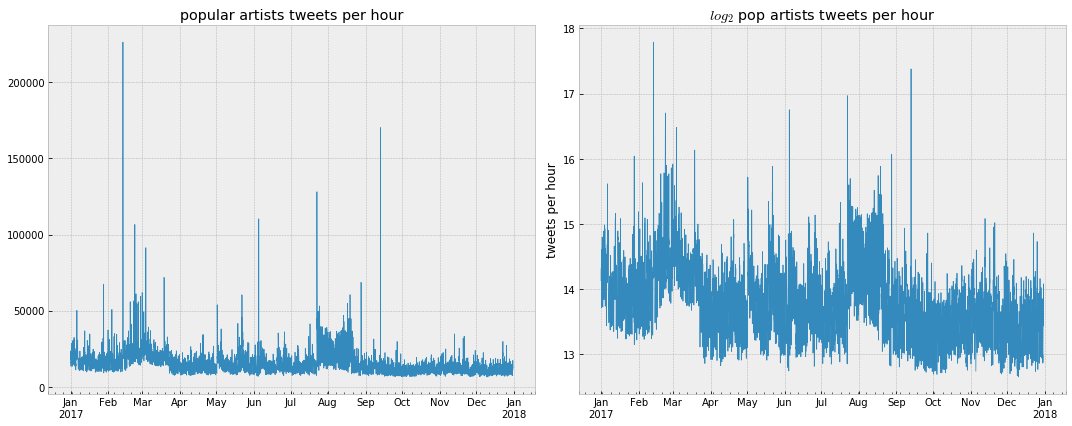

In [70]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (15, 6))
[ax.xaxis.label.set_visible(False) for ax in axes.ravel()]

print(spotify_df.sum())
print(spotify_df.describe())
(spotify_df
 .pipe(plot_ts, raw=True,
       custom_ax=axes[0],
       title="popular artists tweets per hour"));
(spotify_df
 .pipe(np.log2)
 .pipe(plot_ts,
       raw=True,
       custom_ax=axes[1],
       title="$log_2$ pop artists tweets per hour"));

Let's put our signals on the same scale to assess visual differences. We'll also plot the weekly rolling Pearson correlation between the two signals

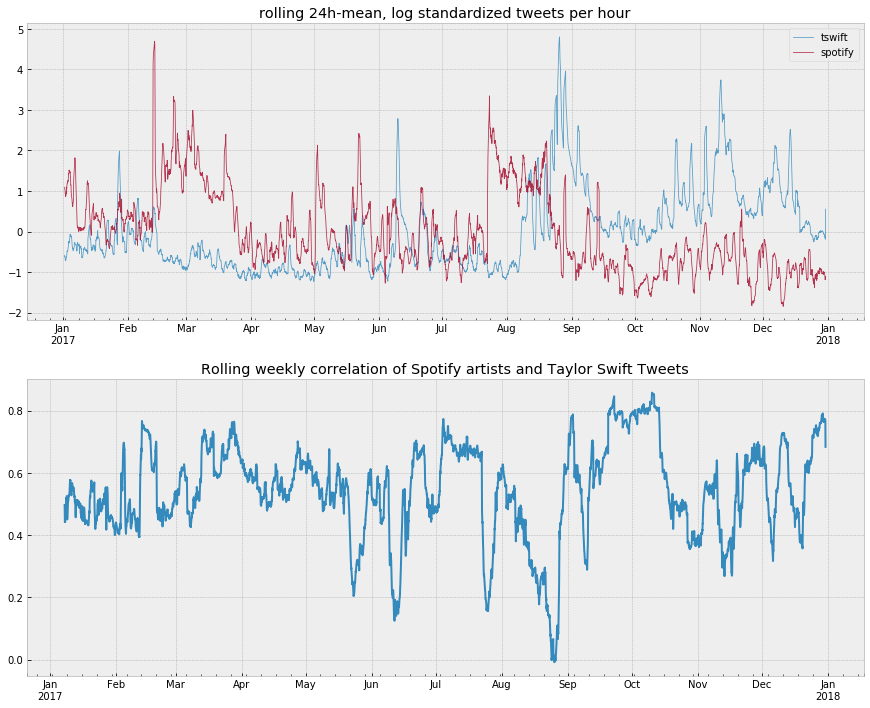

In [71]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize = (15, 12))
_ = [ax.xaxis.label.set_visible(False) for ax in axes.ravel()]

(df
 .assign(spotify=spotify_df["count"]) # creates a new column in the dataframe called "spotify"
 .rename(columns={"count": "tswift"})
 .rolling(24)
 .mean()
 .pipe(np.log)
 .pipe(standardize)
 .plot(ax=axes[0], lw=0.8, alpha=0.8, title="rolling 24h-mean, log standardized tweets per hour")
);

(df
 .assign(spotify=spotify_df["count"]) 
 .rename(columns={"count": "tswift"})
 .pipe(np.log)
 .rolling(24*7)
 .corr()
 ["spotify"]
 .unstack()
 ["tswift"]
 .plot(ax=axes[1], title="Rolling weekly correlation of Spotify artists and Taylor Swift Tweets")
);

Obviously, our signal has a lot of daily periodicity, but let's start by dividing our Taylor Swift signal with this Spotify signal, using the Spotify signal as a baseline. We'll show four ways of doing this point-by-point division - 

1. simple division
2. division after minor smoothing with a simple moving average
3. simple division -> log transform
4. log-transform both signals, then divide by the $SMA_{24}$

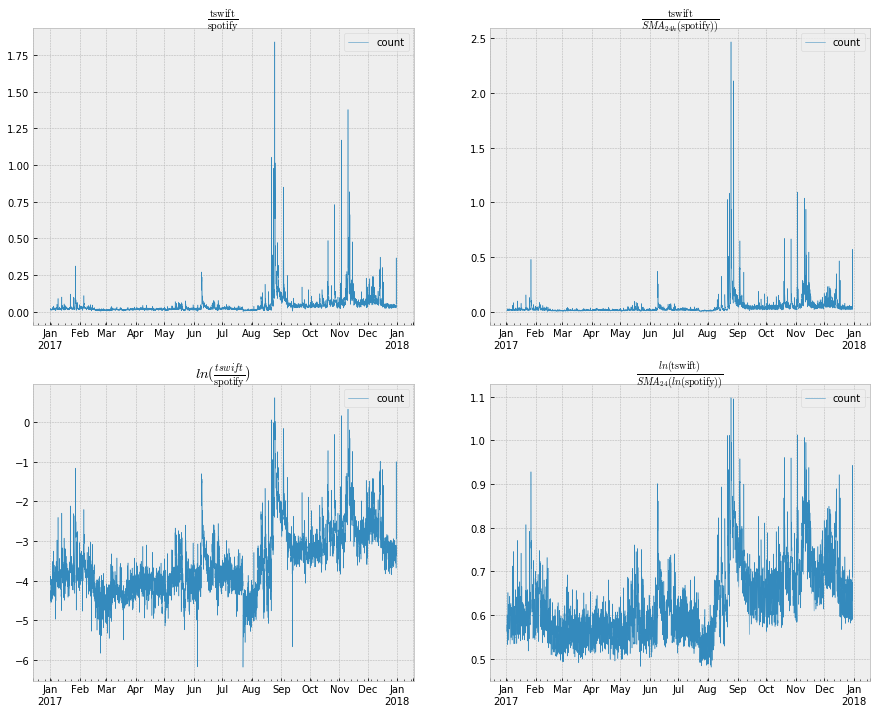

In [72]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize = (15, 12))
[ax.xaxis.label.set_visible(False) for ax in axes.ravel()]

(df
 .div(spotify_df)
 .plot(title=r"$\frac{\mathrm{tswift}}{\mathrm{spotify}}$",
       lw=0.5,
       ax=axes[0][0]));

(df
 .div(spotify_df.rolling(24).mean())
 .plot(title=r"$\frac{\mathrm{tswift}}{SMA_{24h}(\mathrm{spotify}))}$",
       lw=0.5,
       ax=axes[0][1]));

(df
 .pipe(np.log)
 .div(spotify_df.pipe(np.log).rolling(24).mean())
 .plot(title=r"$\frac{ln(\mathrm{tswift})}{SMA_{24}(ln(\mathrm{spotify))}}$",
       lw=0.5,
       ax=axes[1][1]));

(df
 .div(spotify_df)
 .pipe(np.log)
 .plot(title=r"$ln(\frac{tswift}{\mathrm{spotify}})$",
       lw=0.5,
       ax=axes[1][0]));



Each choice of a numerator and denominator affects the overall shape, outcome scale, and minor variations. You will have to determine what makes sense for your data, but in general, you will want to think about putting your signal in context. This is also very useful for comparing two direct signals (direct signal being some specific phenomena with something else, like Taylor Swift vs Rihanna). 

In the below plot, notice how the normalized signal has an ever-so-slightly different shaped and exacerbated spikes, on the same scale. 

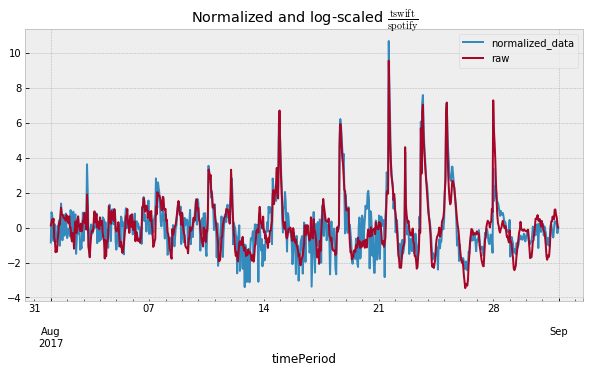

In [73]:
(df
 .div(spotify_df)
 .rename(columns={"count": "normalized_data"})
 .assign(raw=df["count"])
 .pipe(np.log)
 .pipe(detrender)
 .dropna()
 .pipe(standardize)
 ["2017-08"]
 .plot(title=r"Normalized and log-scaled $\frac{\mathrm{tswift}}{\mathrm{spotify}}$",
       #subplots=True,
       sharey=True
      )
);



Below, let's compare the sample-normalized tweet counts to a non-sampled-normalized version and plot our detected spikes via the log-detrended-standardized method.

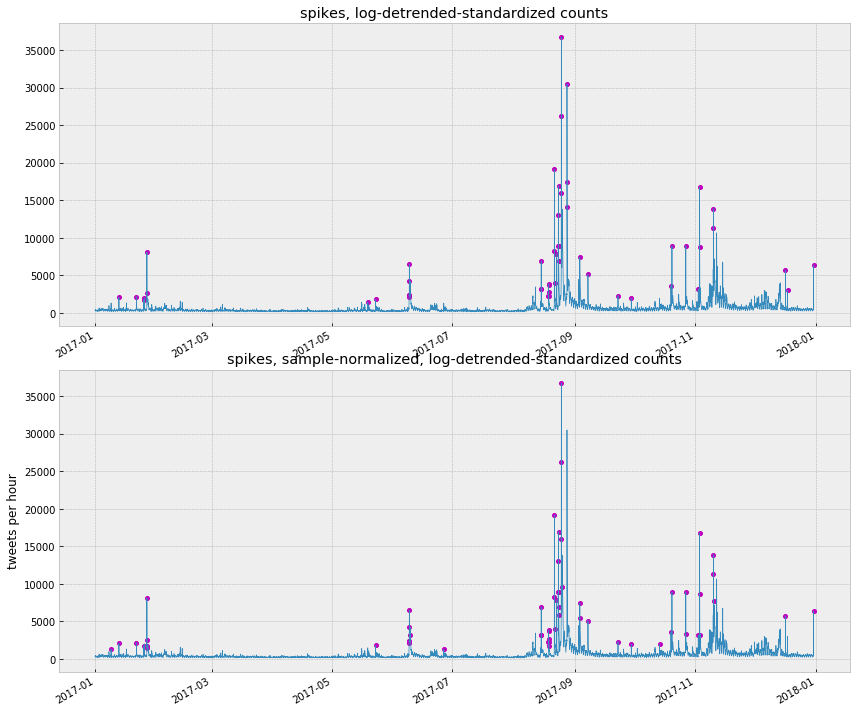

In [74]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize = (12, 10))
[ax.xaxis.label.set_visible(False) for ax in axes.ravel()]

plot_ts(df,
        raw=True,
        title="spikes, log-detrended-standardized counts",
        custom_ax=axes[0],
        date_markers=(df
                      .pipe(np.log)
                      .pipe(detrender)
                      .dropna()
                      .pipe(standardize)
                      .query("count >= 4")
                      .index));

plot_ts(df,
        raw=True,
        title="spikes, sample-normalized, log-detrended-standardized counts",
        custom_ax=axes[1],
        date_markers=(df
                      .div(spotify_df)
                      .pipe(np.log)
                      .pipe(detrender)
                      .pipe(standardize)
                      .query("count >= 4")
                      .index));


Mostly, we see that most of the points we've detected are the same, but there are some minor differences in the mix too. It would be wise to inspect the differing points to understand what differences are arising, which can help you either refine your normalization signal, understand your signal of interest, or refine your thresholds.

### Recap


Social data is a bit messy. It's not at all "normal", often will have trends, and will have huge spikes in volume without seeming periodicity. 

We covered most of the basics of working with time-series data, including basic transformations, detrending, mean and median deviance, standardization, normalizing by another sample, and so forth. These methods all work well to detect abrupt changes in Twitter data via threshold-based methods and are easy to compute and understand.

Note that we haven't touched several big areas of time-series analysis that all apply to Twitter data:

- *modeling* a time-series signal via autoregressive methods or other
- distanced-based normalization
- correlations
- probabilistic methods for change detection
- time series mining
- recurrent neural networks for time-series modeling

We also only looked at Tweet volumes, and not other interesting areas that also fit as time-series problems, e.g.:

- user-based signals (Tweets per user in buckets)
- language evolution
- topic virality 


I hope to cover some these methods and topics in future posts, but this information will be enough to get started with working with Twitter data from a time-series perspective.

Before we go, let's look at how you could quickly gather and compute these points for other signals of interest. I've defined a set of pop-star rules, so let's collect those for the last six months or so and run one of our simple detectors.

In [39]:
from timeseries_utils import pop_star_rules

[print(l) for l in pop_star_rules];

{'artist': 'katy_perry', 'rule': '("katy perry" OR @katyperry) -is:retweet lang:en'}
{'artist': 'rihanna', 'rule': '(rihanna OR @rihanna) -is:retweet lang:en'}
{'artist': 'lady_gaga', 'rule': '("lady gaga" OR @ladygaga) -is:retweet lang:en'}
{'artist': 'ariana_grande', 'rule': '("ariana grande" OR @arianagrande) -is:retweet lang:en'}
{'artist': 'beyonce', 'rule': '(beyonce OR @beyonce) -is:retweet lang:en'}
{'artist': 'selena_gomez', 'rule': '("selena gomez" OR @selenagomez) -is:retweet lang:en'}


Before you run this, know that it will use a large number of API calls.

In [40]:
def gather_dfs(rule_list, from_date=None, end_date=None):
    """Quick function to gather different counts endpoint
    results to a single dataframe with multiple columns.
    
    """
    if from_date is None:
        print("collecting last 30 days counts by default")
    
    else:
        print(f"collecting data from {from_date} to {end_date}")
        
    dfs = []
    for rule_meta in rule_list:
        payload = gen_rule_payload(rule_meta["rule"],
                                   from_date=from_date,
                                   to_date=end_date,
                                   count_bucket="hour")
        
        res = collect_results(rule=payload,
                              max_results=365*24,
                              result_stream_args=search_args)
        df = (df_from_counts(res)
              .rename(columns={"count": rule_meta["artist"]}))
        
        dfs.append(df)
    return pd.concat(dfs, axis=1)

In [41]:
pop_stars = gather_dfs(pop_star_rules, from_date="2017-05-01", end_date="2017-12-31")

collecting data from 2017-05-01 to 2017-12-31


In [42]:
print(f"api calls used: {ResultStream.session_request_counter}")

api calls used: 92


Let's plot each of them with our logged, detrended, MAD-normalized threshold detector.

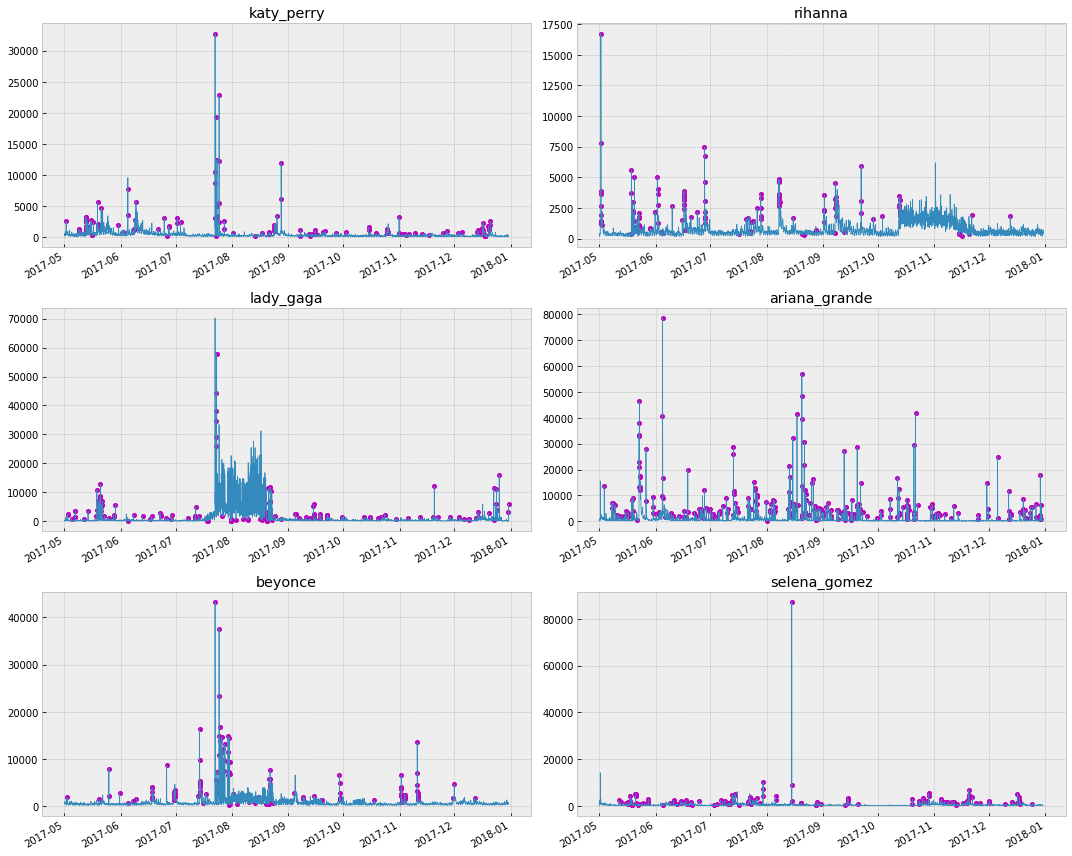

In [43]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize = (15, 12));
_ = [ax.xaxis.label.set_visible(False) for ax in axes.ravel()];

for star, idx in zip(pop_stars.columns, it.product([0, 1, 2], [0, 1])):
    row, col = idx
    # subsetting since there are a lot more dates in this df
    divider = spotify_df.reindex(pop_stars.index).values
    date_markers = (pop_stars[star]
                    .to_frame()
                    .div(divider, axis=1) 
                    .pipe(np.log)
                    .pipe(detrender, method=np.median)
                    .dropna()
                    .pipe(mad_normalize)
                    .query("{} >= 4".format(star))
                    .index)
    plot_ts(pop_stars[star],
            raw=True,
            y_label=False,
            title=star,
            custom_ax=axes[row][col],
            date_markers=date_markers);

There is something funny going on with Lady Gaga's July/August data, but inspecting the Tweets will again be left as an exercise for the reader.

We can expand this process out to anything you can imagine with Twitter data quickly. I'll run through a few more examples - let's make some quick rules that relate to data science, bitcoin, climate change, and machine learning.

In [44]:
other_rules = [{'artist': 'data_science',
                'rule': '(data science) OR "data scientists" OR #datascience'},
               {'artist': 'bitcoin',
                'rule': 'bitcoin OR ethereum OR blockchain OR btc OR (block chain)'},
               {'artist': 'global_warming',
                'rule': '(global warming) OR (climate change) OR climate OR (extreme weather)'},
               {'artist': 'ai',
                'rule': '(machine learning) OR (artificial intelligence) OR #ai OR ("deep learning")'}
              ]

And collect them:

In [45]:
other_dfs = gather_dfs(other_rules, from_date="2017-05-01", end_date="2017-12-31")

collecting data from 2017-05-01 to 2017-12-31


In [46]:
print(f"api calls used: {ResultStream.session_request_counter}")

api calls used: 124


And plot them like before, with our log-detrended-mad-normalized threshold detector, but notice that I've lowered the threshold a bit here to points > 2.5.

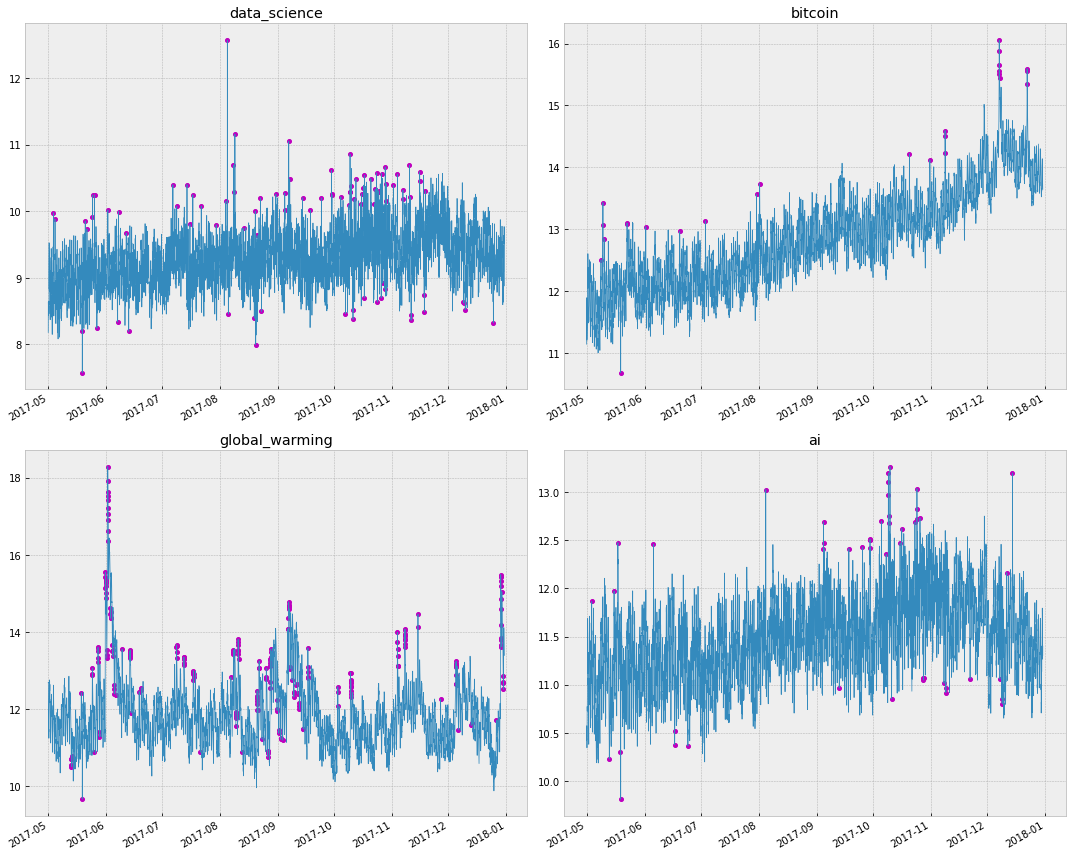

In [47]:
MAD_THRESHOLD = 2.5
fig, axes = plt.subplots(nrows=2, ncols=2, figsize = (15, 12));
_ = [ax.xaxis.label.set_visible(False) for ax in axes.ravel()];

for label, idx in zip(other_dfs.columns, it.product([0, 1], [0, 1])):
    row, col = idx
    date_markers = (other_dfs[label]
                    .to_frame()
                    .pipe(np.log)
                    .pipe(detrender, method=np.median)
                    .dropna()
                    .pipe(mad_normalize)
                    .query(f"{label} >= @MAD_THRESHOLD")
                    .index)
    plot_ts(np.log2(other_dfs[label]),
            raw=True,
            y_label=False,
            title=label,
            custom_ax=axes[row][col],
            date_markers=date_markers
           );

## Wrap-up


I hope that you enjoyed this tutorial. Please feel free to reach out with questions or comments and to use this code as you see fit. We hope to write about more advanced time-series analysis methods soon.